<h3>Сбор данных</h3>
    
Производился через beautifulsoup путем сбора всех ссылок, регионов и ТИКов и затем сбора информации по отдельным страницам местных избиркомов

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import multiprocessing
import pandas as pd 

#Создание полей заголовков
r = requests.get('http://www.vybory.izbirkom.ru/region/izbirkom?action=show&global=true&root=42000004&tvd=2042000367645&vrn=100100084849062&prver=0&pronetvd=null&region=2&sub_region=2&type=227&vibid=2042000367648')
soup = BeautifulSoup(r.text, 'lxml') 
titles = [i.find_all('nobr') for i in soup.find_all('tr')[18:40]]
titles = [i[1].text for i in titles if len(i)>1]
headers = ['Название региона', 'Название ТИК', 'Номер УИК']
headers.extend(titles)

#Получение ссылок на региональные сайты, названий регионов и ТИКов
r = requests.get('http://www.vybory.izbirkom.ru/region/region/izbirkom?action=show&root=1&tvd=100100084849066&vrn=100100084849062&region=0&global=1&sub_region=0&prver=0&pronetvd=null&vibid=100100084849066&type=227')
soup = BeautifulSoup(r.text, 'lxml') 

#список регионов
regions = [i['href'] for i in soup.find_all('a')[4:]]
regions_text = [i.text for i in soup.find_all('a')[4:]]
hrefs = []

#Все регионы кроме регионов за пределами РФ
for url, region in zip(regions[:-2],regions_text[:-2]):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    tiks = [i['href'] for i in soup.find_all('a')[5:]]
    tiks_text = [i.text for i in soup.find_all('a')[5:]]
    for item, tik in zip(tiks, tiks_text):
        r = requests.get(item)
        soup = BeautifulSoup(r.text, 'lxml') 
        hrefs.append([soup.find_all('a')[-2]['href'], region, tik])

#Байконур и другие территории вне РФ
for url, region in zip(regions[-2:],regions_text[-2:]):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml') 
    #т.к. ТИКов нет, регион дублируется
    hrefs.append([soup.find_all('a')[-2]['href'], region, region])

Основной скрипт парсинга страниц, на вход подается ссылка на страницу, регион и ТИК, а так-же список ссылок-исключений, т.е. ТИКов в которых только один УИК 

Скрипт и универсален и работает для всех регионов, за исключением Калининградской области для которой страница не парсится через lxml и приходится использовать намного более медленный html5lib

In [2]:
#ТИКи с одним участком
exceptions = [i[0] for i in [hrefs[662], hrefs[1596], hrefs[1626], hrefs[2180], hrefs[2260], hrefs[2268], hrefs[2364]]]
def parse(link, exceptions):
    url = link[0]
    region = link[1]
    tik = link[2]
    r = requests.get(url)
    #исключение для Калиниграда
    if region == 'Калининградская область':
        soup = BeautifulSoup(r.text, 'html5lib')
        data = [i.find_all('b') for i in soup.find_all('tr')[41:69]]
        data = [[i.text for i in line] for line in data if len(line)>0][6:] 
        data = np.array(data).transpose()
        uik = [i[0] for i in [[k.text for k in i.find_all('nobr') if 'УИК' in k.text] for i in \
                                                                  soup.find_all('td')][83:] if len(i)>0]
        if uik[0]==uik[1]:
            uik = uik[1:]
        uiktik = [[region, tik, z] for z in uik]
        return(np.concatenate((uiktik, data), axis=1))

    soup = BeautifulSoup(r.text, 'lxml') 
    #если ссылки нет исключений то берется множество строк из заведомо большего промежутка, а затем удляются все строки 
    #с длинной меньше 2, таким образом отрезая все ненужные метаданные
    if url not in exceptions:
        data = [i.find_all('b') for i in soup.find_all('tr')[36:75]]
        data = [[i.text for i in line] for line in data if len(line)>1]
    #в случае если участок один то все строки будут иметь длину 1, поэтому нужно брать более узкий промежуток, 
    #полученный опытным путем
    else:
        data = [i.find_all('b') for i in soup.find_all('tr')[41:69]]
        data = [[i.text for i in line] for line in data if len(line)>0]
    #транспонирование данных в нужный нам вид (столбцы - параметры, строки - участки)
    data = np.array(data).transpose()
    #простейшая проверка корректности всех данных
    if len(data[0]) != 20:
        print(link)
    #получение УИКов, как ни странно для всех сайтов работает как надо
    uik = [i[0] for i in [[k.text for k in i.find_all('nobr') if 'УИК' in k.text] for i in \
                                                                      soup.find_all('td')][83:] if len(i)>0]
    #для некоторых сайтов первый УИК в коде таблицы дублируется, в таком случае он удаляется
    if uik[0]==uik[1]:
        uik = uik[1:]
    uiktik = [[region, tik, z] for z in uik]
    #функция возвращает массив в формате, требуемом в условии
    return(np.concatenate((uiktik, data), axis=1))

Сбор данных и сохранение

In [3]:
data = []
for link in hrefs:
    data.append(parse(link, exceptions))
result = np.vstack((headers,np.concatenate(data)))
pd.DataFrame(result).to_csv("data.csv", header=None, index=None)

<h4>Результат

In [4]:
import pandas as pd
data = pd.read_csv('data.csv')
data.head()

,Название региона,Название ТИК,Номер УИК,"Число избирателей, включенных в список избирателей","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям, проголосовавшим досрочно","Число избирательных бюллетеней, выданных в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных вне помещения для голосования в день голосования",Число погашенных избирательных бюллетеней,Число избирательных бюллетеней в переносных ящиках для голосования,...,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Бабурин Сергей Николаевич,Грудинин Павел Николаевич,Жириновский Владимир Вольфович,Путин Владимир Владимирович,Собчак Ксения Анатольевна,Сурайкин Максим Александрович,Титов Борис Юрьевич,Явлинский Григорий Алексеевич
0,Республика Адыгея (Адыгея),Адыгейская,УИК №1,2256,2181,0,2107,62,12,62,...,0,0,0,137,32,1977,14,0,1,5
1,Республика Адыгея (Адыгея),Адыгейская,УИК №2,2700,2633,0,2575,41,17,41,...,0,0,15,86,65,2389,13,5,6,15
2,Республика Адыгея (Адыгея),Адыгейская,УИК №3,2858,2752,0,2664,75,13,75,...,0,0,1,62,13,2645,6,3,4,0
3,Республика Адыгея (Адыгея),Адыгейская,УИК №4,2066,2034,0,1857,142,35,142,...,0,0,5,288,12,1642,21,6,2,2
4,Республика Адыгея (Адыгея),Адыгейская,УИК №5,700,714,0,676,11,27,11,...,0,0,2,44,6,624,6,0,0,2


<h3>Spark

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import max, min, stddev, round, count, col
from functools import reduce
from operator import add

spark = SparkSession.builder.appName("PySpark").getOrCreate()

Чтение даных, более удобные названия для колонок

In [6]:
df = spark.read.csv('data.csv', inferSchema=True, header=True).toDF( \
          'Регион','ТИК','УИК', 'избиратели', 'бюллетени', \
          'досрочно', 'внутри', 'снаружи', 'погашенные', \
          'переносные ящики', 'стационарные ящики', \
          'недействительные', 'действительные', 'утраченные', 'неучтенные', \
          'Бабурин', 'Грудинин', 'Жириновский', 'Путин', \
          'Собчак', 'Сурайкин', 'Титов', 'Явлинский')

Создание таблицы явки по всем регионам путем отбора и суммирования нужных колонок (изначально делал по кандидатам, но число получалось значительно ниже из-за отбракованных бюллетеней)

In [7]:
voted = ['досрочно', 'внутри', 'снаружи']

presence = df.groupBy('Регион') \
  .sum('избиратели', *voted) \
  .withColumn('сумма', reduce(add, [col(x) for x in ['sum('+i+')' for i in voted]])) \
  .select('Регион', 'sum(избиратели)', 'сумма') \
  .sort('sum(избиратели)', ascending=False) \
  .withColumn('Явка', col('сумма') / col('sum(избиратели)') * 100) \
  .select('Регион', 'Явка') \
  .sort('Явка', ascending=False) 

presence.show(10)

+--------------------+-----------------+
|              Регион|             Явка|
+--------------------+-----------------+
|Территория за пре...|98.06986984380843|
|     Республика Тыва|93.66369316170004|
|Ямало-Ненецкий ав...|91.90125747324196|
|Кабардино-Балкарс...|91.80157863562131|
|Чеченская Республика|91.54001705101919|
|Республика Северн...|89.98810071492768|
| Республика Дагестан|87.47795414462081|
|Карачаево-Черкесс...|87.40544668203033|
| Кемеровская область|83.22733516003962|
|Чукотский автоном...| 82.2813869592439|
+--------------------+-----------------+
only showing top 10 rows



Перевод результата в pandas dataframe и визуализация явки для каждого 16-го региона

In [8]:
presence = presence.toPandas()

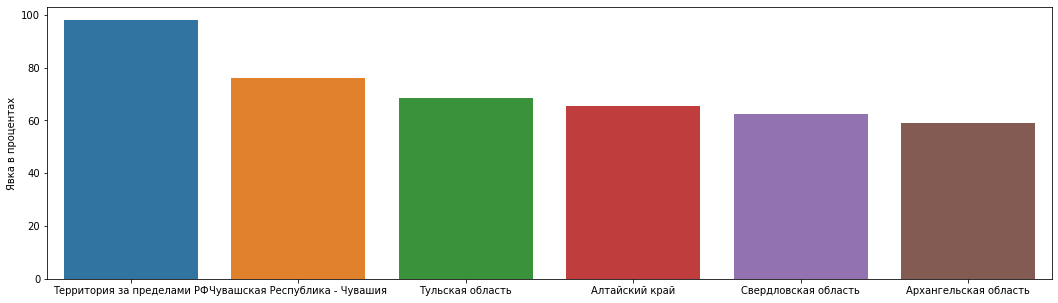

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(18,5))
ax = sns.barplot(x=presence['Регион'][::16], y=presence['Явка'][::16]) 
ax.set(ylabel='Явка в процентах', xlabel = '')
plt.show()

Избирательный участок на котором кандидат набрал наибольшее число голосов

In [10]:
def get_candidate(name):
    stat = df.filter(col(name) >= 300) \
      .select('Регион','ТИК','УИК', name) \
      .groupBy('Регион','ТИК','УИК') \
      .agg(max(name).alias('Число голосов')) \
      .select('Регион', 'ТИК', 'УИК', 'Число голосов') \
      .sort('Число голосов', ascending=False)
    return stat

#Пример 
get_candidate('Путин').show(1)

+--------------------+--------------------+---------+-------------+
|              Регион|                 ТИК|      УИК|Число голосов|
+--------------------+--------------------+---------+-------------+
|Территория за пре...|Территория за пре...|УИК №8342|         7221|
+--------------------+--------------------+---------+-------------+
only showing top 1 row



Регион, где разница между ТИК с наибольшей явкой и наименьшей максимальна

In [11]:
diff = df.groupBy('Регион','ТИК') \
  .sum('избиратели', 'досрочно', 'внутри', 'снаружи') \
  .withColumn('сумма', reduce(add, [col(x) for x in ['sum(досрочно)','sum(внутри)', 'sum(снаружи)']])) \
  .withColumn('Явка', col('сумма') / col('sum(избиратели)') * 100) \
  .select('Регион', 'ТИК', 'Явка') \
  .groupBy('Регион') \
  .agg((max('Явка') - min('Явка')).alias('Разница')) \
  .sort('Разница', ascending=False) 
diff.show(10)
diff = diff.toPandas()

+--------------------+------------------+
|              Регион|           Разница|
+--------------------+------------------+
|Архангельская обл...|  49.8591648406849|
| Сахалинская область|48.425080358447666|
| Республика Дагестан| 46.38987836388278|
|   Самарская область|41.698130506775954|
|   Красноярский край|41.593725903311665|
| Саратовская область| 40.03895056872615|
|Республика Татарс...|  39.4714905703235|
|  Краснодарский край| 37.25799222313191|
|Республика Адыгея...|36.020071603446446|
| Республика Калмыкия| 35.80047047156419|
+--------------------+------------------+
only showing top 10 rows



Визуализация разницы

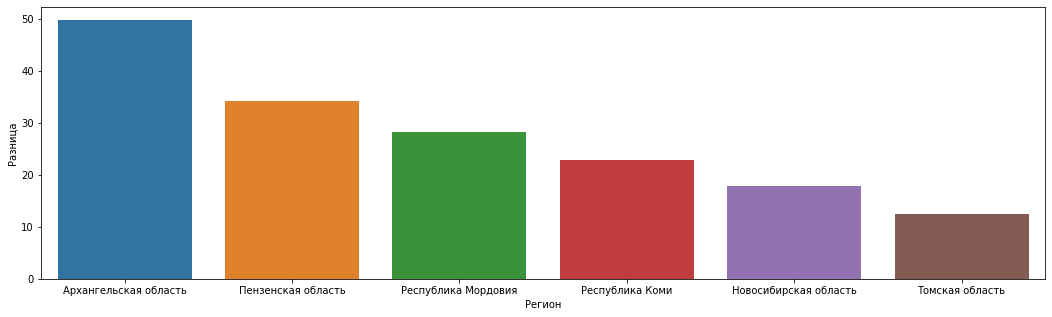

In [12]:
plt.figure(figsize=(18,5))
ax = sns.barplot(x=diff['Регион'][::16], y=diff['Разница'][::16]) 
#ax.set(ylabel='Явка в процентах', xlabel = '')
plt.show()

Дисперсия по явке для каждого региона

In [13]:
std =df.groupBy('Регион','ТИК', 'УИК') \
  .sum('избиратели', 'досрочно', 'внутри', 'снаружи') \
  .withColumn('сумма', reduce(add, [col(x) for x in ['sum(досрочно)','sum(внутри)', 'sum(снаружи)']])) \
  .withColumn('Явка', col('сумма') / col('sum(избиратели)') * 100) \
  .groupBy('Регион') \
  .agg(stddev('Явка').alias('Дисперсия')) \
  .sort('Дисперсия', ascending=False) 
std.show(10)
std = std.toPandas()

+--------------------+------------------+
|              Регион|         Дисперсия|
+--------------------+------------------+
| Сахалинская область|  20.1817713258144|
|     Камчатский край|16.861471602822416|
|  Мурманская область|16.734301006169574|
|     Приморский край|16.641672216989203|
|Республика Адыгея...|16.330124345063627|
|   Самарская область|15.604639730031092|
| Саратовская область|15.419177745102221|
| Республика Калмыкия|15.349925960543612|
| Воронежская область|14.969001494440171|
| Магаданская область|14.380287651040703|
+--------------------+------------------+
only showing top 10 rows



Визуализация дисперсии

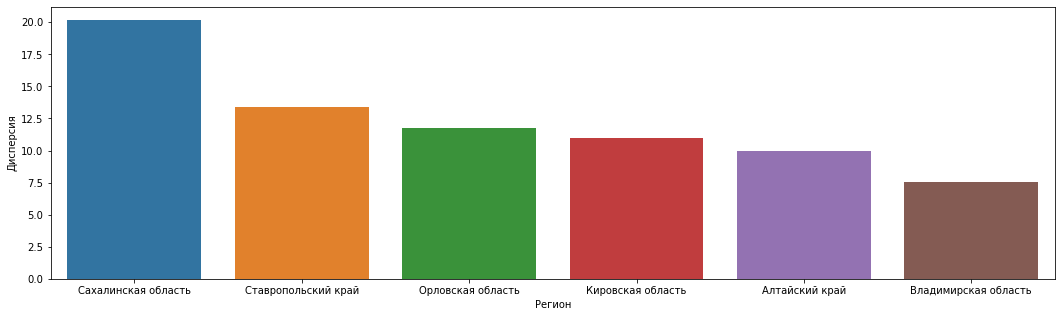

In [14]:
plt.figure(figsize=(18,5))
ax = sns.barplot(x=std['Регион'][::16], y=std['Дисперсия'][::16]) 
#ax.set(ylabel='Явка в процентах', xlabel = '')
plt.show()

Таблицы для кандидатов

In [15]:
#вводится ия кандидата
name = 'Путин'

#вывод явки и процента голосов за кандидата на участке
percent = df.groupBy('Регион','ТИК', 'УИК',name) \
  .sum('избиратели', 'досрочно', 'внутри', 'снаружи') \
  .withColumn('Явка', reduce(add, [col(x) for x in ['sum(досрочно)', 'sum(внутри)', 'sum(снаружи)']])) \
  .withColumn('Процент голосов', round(col(name) / col('Явка') * 100)) \
  .select('Регион','ТИК','УИК', 'Явка', 'Процент голосов') \
  .sort('Явка', ascending=False) 
percent.show(10)

+--------------------+--------------------+---------+----+---------------+
|              Регион|                 ТИК|      УИК|Явка|Процент голосов|
+--------------------+--------------------+---------+----+---------------+
|Территория за пре...|Территория за пре...|УИК №8342|7746|           93.0|
|Территория за пре...|Территория за пре...|УИК №8042|7040|           82.0|
|Территория за пре...|Территория за пре...|УИК №8159|6944|           93.0|
|Территория за пре...|Территория за пре...|УИК №8179|6067|           93.0|
|Территория за пре...|Территория за пре...|УИК №8206|5719|           95.0|
|Территория за пре...|Территория за пре...|УИК №8000|5297|           90.0|
|Территория за пре...|Территория за пре...|УИК №8158|5278|           77.0|
|Территория за пре...|Территория за пре...|УИК №8218|5263|           94.0|
|Территория за пре...|Территория за пре...|УИК №8297|4916|           93.0|
|Территория за пре...|Территория за пре...|УИК №8026|4879|           91.0|
+--------------------+---

Вывод числа участков с процентами голосов

In [16]:
votes = percent.groupBy('Процент голосов')\
    .agg(count('Процент голосов').alias('Число УИКов')) \
    .sort('Процент голосов', ascending=False) 
votes.show(20)

+---------------+-----------+
|Процент голосов|Число УИКов|
+---------------+-----------+
|          100.0|        242|
|           99.0|        334|
|           98.0|        638|
|           97.0|        770|
|           96.0|        915|
|           95.0|       1285|
|           94.0|       1265|
|           93.0|       1474|
|           92.0|       1577|
|           91.0|       1566|
|           90.0|       1871|
|           89.0|       1541|
|           88.0|       1725|
|           87.0|       1833|
|           86.0|       2065|
|           85.0|       2374|
|           84.0|       2314|
|           83.0|       2592|
|           82.0|       2637|
|           81.0|       2981|
+---------------+-----------+
only showing top 20 rows



С подписями на оси X беда, их слишком много, но каждый из столбцов соответсвует одному проценту по возрастанию

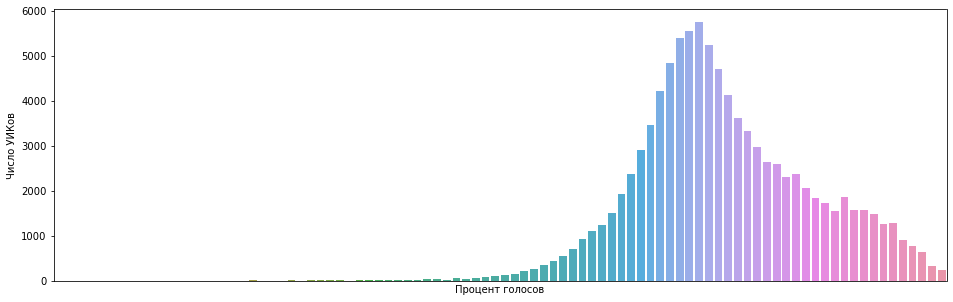

In [17]:
result = votes.toPandas()
plt.figure(figsize=(16,5))
plt.tick_params(
    axis='x',         
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
ax = sns.barplot(x=result['Процент голосов'], y=result['Число УИКов']) 
plt.show()